In [1]:
import sqlite3
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pylab
from datetime import datetime
from collections import Counter

In [2]:
# Create a SQL connection to our SQLite database

conn = sqlite3.connect("FPA_FOD_20170508.sqlite")
cur = conn.cursor()

In [3]:
# Getting Table Column metadata

cur.execute('PRAGMA table_info("Fires")')
cur.fetchall()

[(0, 'OBJECTID', 'integer', 1, None, 1),
 (1, 'FOD_ID', 'int32', 0, None, 0),
 (2, 'FPA_ID', 'text(100)', 0, None, 0),
 (3, 'SOURCE_SYSTEM_TYPE', 'text(255)', 0, None, 0),
 (4, 'SOURCE_SYSTEM', 'text(30)', 0, None, 0),
 (5, 'NWCG_REPORTING_AGENCY', 'text(255)', 0, None, 0),
 (6, 'NWCG_REPORTING_UNIT_ID', 'text(255)', 0, None, 0),
 (7, 'NWCG_REPORTING_UNIT_NAME', 'text(255)', 0, None, 0),
 (8, 'SOURCE_REPORTING_UNIT', 'text(30)', 0, None, 0),
 (9, 'SOURCE_REPORTING_UNIT_NAME', 'text(255)', 0, None, 0),
 (10, 'LOCAL_FIRE_REPORT_ID', 'text(255)', 0, None, 0),
 (11, 'LOCAL_INCIDENT_ID', 'text(255)', 0, None, 0),
 (12, 'FIRE_CODE', 'text(10)', 0, None, 0),
 (13, 'FIRE_NAME', 'text(255)', 0, None, 0),
 (14, 'ICS_209_INCIDENT_NUMBER', 'text(255)', 0, None, 0),
 (15, 'ICS_209_NAME', 'text(255)', 0, None, 0),
 (16, 'MTBS_ID', 'text(255)', 0, None, 0),
 (17, 'MTBS_FIRE_NAME', 'text(50)', 0, None, 0),
 (18, 'COMPLEX_NAME', 'text(255)', 0, None, 0),
 (19, 'FIRE_YEAR', 'int16', 0, None, 0),
 (20, '

In [4]:
# Query A

cur.execute('select * from Fires')
f = cur.fetchone()
for value,item in enumerate(f):
    print(value, item)


0 1
1 1
2 FS-1418826
3 FED
4 FS-FIRESTAT
5 FS
6 USCAPNF
7 Plumas National Forest
8 0511
9 Plumas National Forest
10 1
11 PNF-47
12 BJ8K
13 FOUNTAIN
14 None
15 None
16 None
17 None
18 None
19 2005
20 2453403.5
21 33
22 1300
23 9.0
24 Miscellaneous
25 2453403.5
26 33
27 1730
28 0.1
29 A
30 40.03694444
31 -121.00583333
32 5.0
33 USFS
34 CA
35 63
36 063
37 Plumas
38 b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@|\x01\x00\x00\x00\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@\xfe'


In [5]:
# Query A
cur.execute('select NWCG_REPORTING_AGENCY, SOURCE_REPORTING_UNIT, STATE, OWNER_CODE, OWNER_DESCR from Fires')
agency = cur.fetchall()


In [6]:
# Query B
cur.execute('select STAT_CAUSE_CODE, DISCOVERY_DATE, CONT_DATE, FIRE_SIZE, DISCOVERY_TIME, CONT_TIME from Fires where FIRE_SIZE>=1000;')
datetime_df = cur.fetchall()


In [7]:
# Query C
cur.execute('select latitude, longitude from Fires where Fire_Year="1995";')
df_1995 = cur.fetchall()

In [8]:
# Query D
cur.execute('select latitude, longitude, Fire_Year, Fire_Size, Fire_Size_Class, FIRE_NAME from Fires where Fire_Size >= 100;')
df_100_plus = cur.fetchall()

In [9]:
# Query E
cur.execute('select NWCG_REPORTING_AGENCY, latitude, longitude from Fires f where f.NWCG_REPORTING_AGENCY = "BIA" or f.NWCG_REPORTING_AGENCY = "TRIBE";')
tribe = cur.fetchall()

In [10]:
# Be sure to close the connection
conn.close()

In [11]:
# Formatting Query E into dataframe
native = []
lat = []
long = []

for t in tribe:
    native.append(t[0])
    lat.append(t[1])
    long.append(t[2])

tribe_df = pd.DataFrame({"native": native, "lat": lat, "long": long})
tribe_df.to_csv("csv/tribe_df.csv")

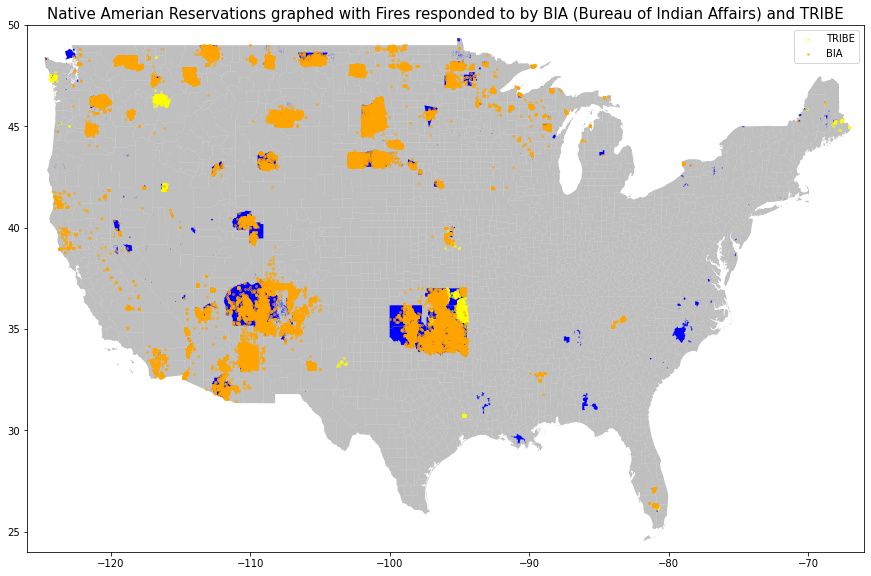

In [13]:
# Graphing Query E

# Designate coordinate system
crs = "EPSG:4326"

# Zip x and y coordinates into single feature
tribe_geo = [Point(xy) for xy in zip(tribe_df["long"], tribe_df['lat'])]

# Create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(tribe_df, crs=crs, geometry=tribe_geo)

street_map = gpd.read_file("shape/tribe_map/tl_2017_us_aiannh.shp")
street_map2 = gpd.read_file("shape/us_map2/cb_2018_us_county_500k.shp")

# Create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))

# Add .shp mapfile to axes
street_map2.plot(ax=ax, color='grey', alpha=0.5)
street_map.plot(ax=ax, color='blue')

# Assign size of points using markersize
geo_df[geo_df['native'] == "TRIBE"].plot(ax=ax, color='yellow', markersize=4, label="TRIBE", alpha=0.5)
geo_df[geo_df['native'] == "BIA"].plot(ax=ax, color='orange', markersize=4, label="BIA", alpha=0.5)

# Add title to graph
plt.title("Native Amerian Reservations graphed with Fires responded to by BIA (Bureau of Indian Affairs) and TRIBE", fontsize=15)

# Set latitude and longitude boundaries for map display
plt.xlim(-126, -66)
plt.ylim(24, 50)
plt.legend()

# show map
plt.savefig("graphs/tribe_fires.png")
plt.show()

In [14]:
# Formatting Query A
agency_df = []
state = []
owner_code = []
owner_desc = []

for agents in agency:
    agency_df.append(agents[0])
    state.append(agents[2])
    owner_code.append(agents[3])
    owner_desc.append(agents[4])

In [15]:
# Formatting Query B
cause_code = []
discovery = []
contained = []
fire_size = []
time = []
con_time = []

for f in datetime_df:

    cause_code.append(f[0])
    discovery.append(f[1])
    contained.append(f[2])
    fire_size.append(f[3])
    time.append(f[4])
    con_time.append(f[5])

# Creating df 
time_df = pd.DataFrame({"cause_code": cause_code, "discovery": discovery, "contained": contained, "fire_size": fire_size, "time": time, "con_time": con_time})
timedf = time_df.dropna()
time_drop_df = timedf.reset_index(drop=True)
   

In [16]:
# Converting datetime to correct format
con_dis = []
con_con = []

for x in range(len(time_drop_df)):
    
    time_drop_df['discovery'][x] = pd.to_datetime(time_drop_df['discovery'][x], unit='D', origin='julian')
    time_drop_df['contained'][x] = pd.to_datetime(time_drop_df['contained'][x], unit='D', origin='julian')
    
    time_drop_df['time'][x] = datetime.strptime(time_drop_df['time'][x], '%H%M').time()
    time_drop_df['con_time'][x] = datetime.strptime(time_drop_df['con_time'][x], '%H%M').time()

    a = time_drop_df['discovery'][x].replace(hour=time_drop_df['time'][x].hour, minute=time_drop_df['time'][x].minute)
    b = time_drop_df['contained'][x].replace(hour=time_drop_df['con_time'][x].hour, minute=time_drop_df['con_time'][x].minute)

    con_dis.append(a)
    con_con.append(b)

# Finally getting total fire time
total_time = []

for x,y in zip(con_dis, con_con):
    a = y - x
    total_time.append(a)

final_total_time = pd.DataFrame({"total_time": total_time, "fire_size": time_drop_df['fire_size']})
final_total_time.to_csv("csv/final_time_duration.csv")
final_total_time['total_time'].sort_values(ascending=False).head()

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/miniconda3/lib/python3.7

7334   371 days 14:15:00
5300   312 days 03:00:00
6723   236 days 23:00:00
7689   207 days 03:00:00
6016   204 days 04:44:00
Name: total_time, dtype: timedelta64[ns]

TypeError: Cannot cast array data from dtype('float64') to dtype('<m8[ns]') according to the rule 'same_kind'

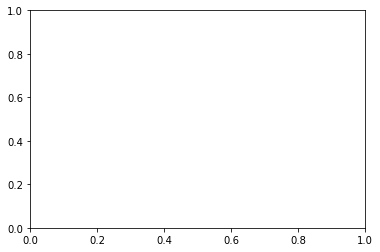

In [17]:
# Plotting Time Duration vs Fire Size
plt.scatter(final_total_time['total_time'], time_drop_df['fire_size'])

ax.legend(loc="best")

plt.title("Fire Size vs Time to Contain for Fires over 1000 acres")
plt.xlabel("Time to Contain")
plt.ylabel("Fire Size")
#plt.savefig("cotton_coffee_sugar.png")
plt.show()

In [19]:
# Formatting Query D

latitude = []
longitude = []
size = []
year = []
letter = []
name = []
geo = []

for f in df_100_plus:
    latitude.append(f[0])
    longitude.append(f[1])
    year.append(f[2])
    size.append(f[3]) 
    letter.append(f[4])
    name.append(f[5])

#Creating Datafile, saving as csv, and loading shape file

df = pd.DataFrame({"longitude": longitude, "latitude": latitude, "size": size, "year": year, "class_letter": letter, "name": name})
df_100 = df
df_100.to_csv("csv/df_100.csv")




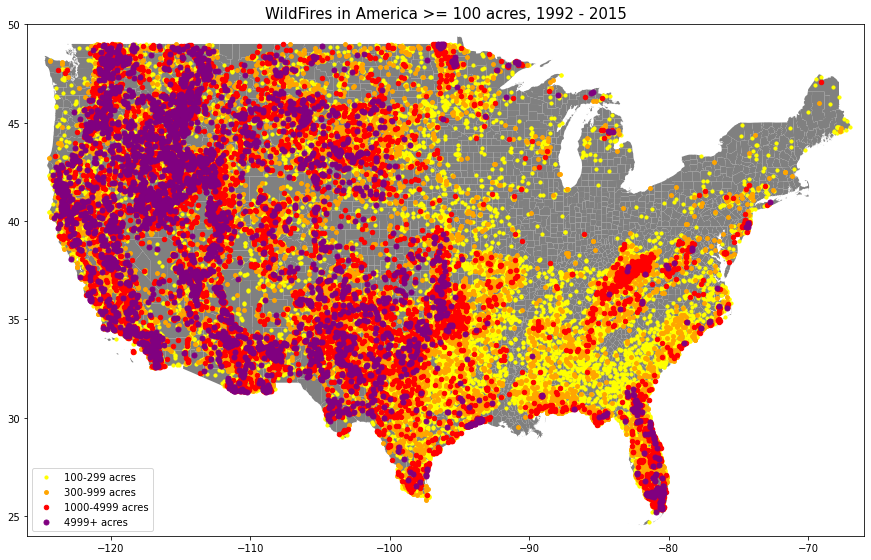

In [21]:
# Loading Shape Files
street_map = gpd.read_file("shape/us_map2/cb_2018_us_county_500k.shp")

# Designate coordinate system
crs = "EPSG:4326"

# Zip x and y coordinates into single feature
geomet = [Point(xy) for xy in zip(df["longitude"], df['latitude'])]

# Create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geomet)

# Create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))

# Add .shp mapfile to axes
street_map.plot(ax=ax, color='grey')

# Assign size of points using markersize
geo_df[geo_df['class_letter'] == "D"].plot(ax=ax, color='yellow', markersize=10, label="100-299 acres")
geo_df[geo_df['class_letter'] == "E"].plot(ax=ax, color='orange', markersize=15, label="300-999 acres")
geo_df[geo_df['class_letter'] == "F"].plot(ax=ax, color='red', markersize=20, label="1000-4999 acres")
geo_df[geo_df['class_letter'] == "G"].plot(ax=ax, color='purple', markersize=25, label="4999+ acres")

# Add title to graph
plt.title("WildFires in America >= 100 acres, 1992 - 2015", fontsize=15)

# Set latitude and longitude boundaries for map display
plt.xlim(-126, -66)
plt.ylim(24, 50)

plt.legend()

# show map
plt.savefig("wildfires.png")
plt.show()
